#### Connect to Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
%cd '/content/gdrive/My Drive/Recommendation_Final_Project'
! ls

/content/gdrive/My Drive/Recommendation_Final_Project
 checkpoints		     model_BPR-max_100.pt
 dataset		     model_CrossEntropy_100.pt
 data_with_new_feature.csv   model_TOP1-max_100.pt
 evaluation_partial.csv      preprocessing.py
 full_metrics_1000_2.csv     __pycache__
 full_metrics_1000.csv	     RCSYS_results.csv
 full_metrics.csv	     README.md
 hyperparameters.py	     Report.gdoc
 knn.py			    'Session_based_recommendations (1) (1) (1).ipynb'
 lib			     tools.py
 LICENSE		     train_data_with_time_spent_3_to_5.csv
 Main.ipynb		     train_data_with_time_spent.csv
 main.py		     trainer.py


#### Requirements

In [8]:
import argparse
import torch
import lib
import numpy as np
import os
import datetime
import pandas as pd
import unittest
import sys
import pathlib
import urllib
import shutil
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [9]:
import hyperparameters as hp
import preprocessing as pp
import main
import trainer
import knn

In [10]:
torch.cuda.manual_seed(hp.get_hyperparams()['seed'])

#### Preprocessing Data


##### Creating Test and Train datasetsets

In [7]:
dataBefore = 'dataset/yoochoose-clicks.dat' #Path to Original Training Dataset "Clicks" File
dataTestBefore = 'dataset/yoochoose-test.dat' #Path to Original Testing Dataset "Clicks" File
dataAfter = 'dataset/' #Path to Processed Dataset Folder
dayTime = 86400 #Validation Only one day = 86400 seconds


In [ ]:
train = pd.read_csv(dataBefore, sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
train.columns = ['SessionID', 'Time', 'ItemID'] #Headers of dataframe
train = pp.convert_time(train)
train.head()

,SessionID,Time,ItemID
0,1,1.396868e+09,214536502
1,1,1.396868e+09,214536500
2,1,1.396868e+09,214536506
3,1,1.396868e+09,214577561
4,2,1.396879e+09,214662742


In [ ]:
test = pd.read_csv(dataTestBefore, sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
test.columns = ['SessionID', 'Time', 'ItemID'] #Headers of dataframe
test = pp.convert_time(test)
test.head()

,SessionID,Time,ItemID
0,5,1.396891e+09,214530776
1,5,1.396891e+09,214530776
2,5,1.396891e+09,214530776
3,10,1.396597e+09,214820942
4,10,1.396598e+09,214826810


In [ ]:
#Remove sessions of length 1
train = pp.removeShortSessions(train)
train = pp.remove_items(train)
train = pp.removeShortSessions(train)

In [ ]:
#In test data only take itemids in test that appear in training
test = test[np.in1d(test.ItemID, train.ItemID)] 
test = pp.removeShortSessions(test)
test.shape

(7925086, 3)

In [ ]:
print('Training Set has', len(train), 'Events, ', train.SessionID.nunique(), 'Sessions, and', train.ItemID.nunique(), 'Items')
train.to_csv(dataAfter + 'recSys15TrainFull.txt', sep='\t', index=False)
print('Testing Set has', len(test), 'Events, ', test.SessionID.nunique(), 'Sessions, and', test.ItemID.nunique(), 'Items\n')
test.to_csv(dataAfter + 'recSys15Test.txt', sep=',', index=False)

Training Set has 31708505 Events,  7981581 Sessions, and 37486 Items
Testing Set has 7925086 Events,  1994993 Sessions, and 34907 Items



##### Splitting Train to train and validation data for hyperparameter optimization

In [ ]:
timeMax = train.Time.max()
sessionMaxTime = train.groupby('SessionID').Time.max()
sessionTrain = sessionMaxTime[sessionMaxTime < (timeMax - dayTime)].index #training split is all sessions that ended before the last 2nd day
sessionValid = sessionMaxTime[sessionMaxTime >= (timeMax - dayTime)].index #validation split is all sessions that ended during the last 2nd day

#Split to train and validation data
trainTR = train[np.in1d(train.SessionID, sessionTrain)]
trainVD = train[np.in1d(train.SessionID, sessionValid)]
#Delete records in validation split where items are not in training split
trainVD = trainVD[np.in1d(trainVD.ItemID, trainTR.ItemID)]
#Delete Sessions in testing split which are less than 2
trainVD = pp.removeShortSessions(trainVD)
#Convert To CSV
print('Training Set has', len(trainTR), 'Events, ', trainTR.SessionID.nunique(), 'Sessions, and', trainTR.ItemID.nunique(), 'Items')
trainTR.to_csv(dataAfter + 'recSys15TrainOnly.txt', sep=',', index=False)
print('Validation Set has', len(trainVD), 'Events, ', trainVD.SessionID.nunique(), 'Sessions, and', trainVD.ItemID.nunique(), 'Items')
trainVD.to_csv(dataAfter + 'recSys15Valid.txt', sep=',', index=False)

Training Set has 31637239 Events,  7966257 Sessions, and 37483 Items
Validation Set has 71222 Events,  15324 Sessions, and 6751 Items


#### Next time, skip Preprocessing Data section and run from here

In [6]:
#Load data from files created
dataAfter = 'dataset/'
trainTR = pd.read_csv(dataAfter + 'recSys15TrainOnly.txt')
trainVD = pd.read_csv(dataAfter + 'recSys15Valid.txt')
# test = pd.read_csv(dataAfter + 'recSys15Test.txt')

#### Due to memory restrictions, we also created a smaller dataset for training and validation
Here, we added a new feature to the input that is time a user spend on a single item. 
For item j : 0$\leq$ j$<$n in given session of length n+1 we define time spend on item j to be (time of item j+1) $-$ (time of item j).


In [ ]:
sample = trainTR[(trainTR['SessionID'] < 3000000)]

In [ ]:
#Create additional feature of time spent on single item in a given session - run this one time only!
sample['time_spent'] = 0
adding_sessions = 0
id = 0
for session in sample['SessionID'].unique():
  session_i = sample[sample['SessionID'] == session].copy()
  session_i = session_i.sort_values(by = 'Time')
  session_i = session_i.reset_index()
  
  for j in range(len(session_i)-1):
    sample['time_spent'][j+adding_sessions] = int(session_i['Time'][j+1] - session_i['Time'][j])
  adding_sessions += len(session_i)
  if id % 10000 == 0 :
    print(f'Processing sesison {id}') 
    sample.to_csv('data_with_new_feature.csv', index = False)
  id += 1  

sample.to_csv('data_with_new_feature.csv', index = False)
sample.head()  

In [37]:
#Load new data
df = pd.read_csv('data_with_new_feature.csv')
df.time_spent = df.time_spent.astype(np.int32)
df.head()

,SessionID,Time,ItemID,time_spent
0,1,1.396868e+09,214536502,180
1,1,1.396868e+09,214536500,37
2,1,1.396868e+09,214536506,133
3,1,1.396868e+09,214577561,0
4,2,1.396879e+09,214662742,41


In [38]:
#Split sample to train and validation
dayTime = 86400 #Validation Only one day = 86400 seconds
dataAfter = 'dataset/' #Path to Processed Dataset Folder

timeMax = df.Time.max()
sessionMaxTime = df.groupby('SessionID').Time.max()
sessionTrain = sessionMaxTime[sessionMaxTime < (timeMax - dayTime)].index #training split is all sessions that ended before the last 2nd day
sessionValid = sessionMaxTime[sessionMaxTime >= (timeMax - dayTime)].index #validation split is all sessions that ended during the last 2nd day
sessionValid
#Split to train and validation data
trainTR_sample = df[np.in1d(df.SessionID, sessionTrain)]
trainVD_sample = df[np.in1d(df.SessionID, sessionValid)]
#Delete records in validation split where items are not in training split
trainVD_sample = trainVD_sample[np.in1d(trainVD_sample.ItemID, trainTR_sample.ItemID)]
#Delete Sessions in testing split which are less than 2
trainVD_sample = pp.removeShortSessions(trainVD_sample)
#Convert To CSV
print('Training Set has', len(trainTR_sample), 'Events, ', trainTR_sample.SessionID.nunique(), 'Sessions, and', trainTR_sample.ItemID.nunique(), 'Items')
trainTR_sample.to_csv(dataAfter + 'train_sample.txt', sep=',', index=False)
print('Validation Set has', len(trainVD_sample), 'Events, ', trainVD_sample.SessionID.nunique(), 'Sessions, and', trainVD_sample.ItemID.nunique(), 'Items')
trainVD_sample.to_csv(dataAfter + 'valid_sample.txt', sep=',', index=False)

Training Set has 8530594 Events,  2117132 Sessions, and 30324 Items
Validation Set has 100414 Events,  27694 Sessions, and 9341 Items


In [ ]:
# sample['time_spent'] = 0
# def add_time_on_item(dataf):
#     dataf = dataf.sort_values(by = 'Time')
#     dataf = dataf.reset_index()
   
#     for j in range(len(dataf)-1):
#         dataf['time_spent'][j] = int(dataf['Time'][j+1] - dataf['Time'][j])
#     return dataf
    
# new_2 = sample.groupby('SessionID').apply(add_time_on_item)
# new_2 = new_2.drop('index', axis = 1).rename(columns = {'SessionID':'S'}).reset_index().drop(['SessionID','level_1'],axis=1).rename(columns = {'S':'SessionID'})


#### Analysis and Visualization

##### Full Training Set

In [7]:
#Length of sessions
session_length = trainTR.groupby('SessionID')['Time'].count()
session_length.describe()
print(f'Length of average session in train set is: {np.round(session_length.mean(),0)}, with standard deviation : {np.round(session_length.std(),2)} ')
print(f'Lengh of max session in train set is: {np.round(session_length.max(),0)}')

Length of average session in train set is: 4.0, with standard deviation : 3.92 
Lengh of max session in train set is: 200


In [8]:
print(f'There are {session_length.count()} session in Training')

There are 7966257 session in Training


In [11]:
#Looking at sessions of average length
limit_to = 9
new_count = session_length[session_length<limit_to].count()
print(f'For visualization on histogram limiting sessions to max length of {limit_to} sessions, covering {np.round(100*new_count/session_length.count(),2)} % of sessions')

Limiting sessions to max length of 9 sessions, covering 92.87 % of sessions


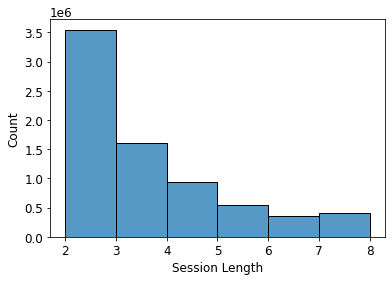

In [15]:
sns.histplot(session_length[session_length<limit_to],binwidth=1)
plt.xlabel('Session Length')
plt.title('Distribution of Session Lengths')
plt.show()


We can see majority of the sessions are only of length 2. This signifies how little information we have on users during their browse sessions.

##### Partial Training Set
The improved model was training on a smaller dataset due to our limitation in RAM while generating the dataset. The below is an analysis of the partial dataset used. 

In [ ]:
session_length = trainTR_sample.groupby('SessionID')['Time'].count()
sns.histplot(session_length[session_length<limit_to],binwidth=1)
plt.xlabel('Session Length')
plt.title('Distribution of Session Lengths')
plt.show()


In [31]:
max_time = 360
new_count = len(trainTR_sample[trainTR_sample['time_spent']<max_time])
all = len(trainTR_sample)
print(f'For visualization on histogram limiting time spent on item to max time of {limit_to} s, covering {np.round(100*new_count/all,2)} % of items')

For visualization on histogram limiting time spent on item to max time of 9 s, covering 94.17 % of items


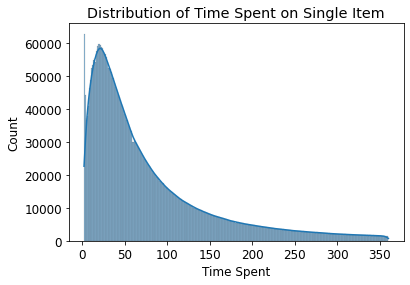

In [32]:
sns.histplot(trainTR_sample[(trainTR_sample['time_spent'] > 2) & (trainTR_sample['time_spent'] < max_time )]['time_spent'], kde = True)
plt.xlabel('Time Spent')
plt.title('Distribution of Time Spent on Single Item')
plt.show()

We can see that the majority of items were viewed for under 60 seconds. Resembling a log-normal distribution. 

### Now that we have our data prepared, let's start training the models!

In [37]:
#Metrics calculated on full datasets - train with trainTR and evaluate with trainVD
#First initiate dataframe to save metrics
final_model_metrics = pd.DataFrame(columns = ['Recall@20', 'MRR@20'])

##### Baseline KNN Model

In [32]:
dataAfter = 'dataset/' #Path to Processed Dataset Folder
trainTR = pd.read_csv(dataAfter + 'recSys15TrainOnly.txt')
trainVD = pd.read_csv(dataAfter + 'recSys15Valid.txt')

In [33]:
KNN_model = knn.ItemKNN()  #Initiate model
KNN_model.fit(trainTR)  #Train with sample data

Training...


  0%|          | 0/37483 [00:00<?, ?it/s]

In [34]:
#Example of prediction returned by KNN
prediction = KNN_model.predict_next(0,2,np.arange(len(trainTR)))
prediction.sort_values(ascending = False).head(10)
#True label is item 3 - not in below results

8996     0.077443
7046     0.063560
1        0.062599
9116     0.059567
0        0.057624
9115     0.042434
9113     0.029832
5543     0.024644
5541     0.021095
12365    0.020591
dtype: float64

In [35]:
recall, mrr = KNN_model.evaluate_sessions(trainTR, trainVD, items=None, cut_off=20)
print(f"Recall = {recall}\n MRR = {mrr}")

Evaluating...


  0%|          | 0/71222 [00:00<?, ?it/s]

Recall = 0.5065655300726323
 MRR = 0.2047699823740699


In [38]:
#Add metrics to report
df_knn = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=['KNN'])
final_model_metrics = final_model_metrics.append(df_knn)
final_model_metrics

,Recall@20,MRR@20
KNN,0.506566,0.20477


#### GRU RNN from article 
Running on full dataset with hyperparameters from article

In [11]:
params = hp.get_hyperparams()

In [13]:
#Put dataframe in DataSet object
train_data = lib.Dataset(os.path.join(params['data_folder'], params['train_data']))
valid_data = lib.Dataset(os.path.join(params['data_folder'], params['valid_data']), itemmap=train_data.itemmap)
#test_data = lib.Dataset(os.path.join(params['data_folder'], 'recSys15Test.txt'), itemmap=train_data.itemmap)

In [20]:
input_size = len(train_data.items)
output_size = input_size
coda = torch.cuda.is_available()


losses = ['BPR-max', 'CrossEntropy', 'TOP1-max']
hidden_states = [100, 1000]
df_rnn = pd.DataFrame(columns = ['Recall@20', 'MRR@20'])

#Based on best hyperparameter optimization in main article
params_per_loss = {'TOP1-max': {'batch_size': 50, 'dropout': 0 , 'lr' : 0.01 , 'momentum' : 0 },
               'BPR-max' : {'batch_size': 50, 'dropout': 0 , 'lr' : 0.05 , 'momentum' : 0.2 },
               'CrossEntropy' : {'batch_size': 500, 'dropout': 0 , 'lr' : 0.01 , 'momentum' : 0 }}

epochs = 4

for hs in hidden_states:
  for ls in losses:
    index = f'{ls} {str(hs)}'
    loss_function = lib.LossFunction(loss_type=ls, use_cuda=coda)
    p = params_per_loss[ls]
    model = lib.model.GRU4REC(input_size, hs, output_size, final_act=params['final_act'],
                            num_layers=params['num_layers'], use_cuda=coda, batch_size=p['batch_size'],
                            dropout_input=params['dropout_input'], dropout_hidden=p['dropout'], embedding_dim=params['embedding_dim'])
    #Init weights
    model.init_model(params['sigma'])
    optimizer = lib.optimizer.Optimizer(model.parameters(), optimizer_type=params['optimizer_type'], lr=p['lr'],
                                  weight_decay=params['weight_decay'], momentum=p['momentum'], eps=params['eps'])
    trnr = trainer.Trainer(model, train_data=train_data, eval_data=valid_data, optim=optimizer, loss_func=loss_function, batch_size=p['batch_size'], model_name = 'RNN')
    if hs == 100:
      epochs = 5
    else: #With 100 hidden states the model is too heavy. Training time is too long so limit to 1 epoch
      epochs = 1  
    trnr.train(0, epochs-1)
    
    model.gru.flatten_parameters()
    evaluation = lib.Evaluation(model, loss_function, use_cuda=coda, k = params['k_eval'])
    loss, recall, mrr = evaluation.eval(valid_data, p['batch_size'])
    
    df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
    display(df2)
    final_model_metrics = final_model_metrics.append(df2)
    final_model_metrics.to_csv('/content/gdrive/My Drive/Recommendation_Final_Project/full_metrics.csv')

Start Epoch # 0


 78%|███████▊  | 1112/1424 [00:02<00:00, 457.60it/s]


Epoch: 0, train loss: 4.2406, loss: 4.2882, recall: 0.5753, mrr: 0.2242, time: 3287.416821718216
Start Epoch # 1


 78%|███████▊  | 1112/1424 [00:02<00:00, 458.95it/s]


Epoch: 1, train loss: 4.2290, loss: 4.2859, recall: 0.5801, mrr: 0.2310, time: 3284.704742193222
Start Epoch # 2


 78%|███████▊  | 1112/1424 [00:02<00:00, 458.66it/s]


Epoch: 2, train loss: 4.2268, loss: 4.2854, recall: 0.5794, mrr: 0.2332, time: 3284.289620399475
Start Epoch # 3


 78%|███████▊  | 1112/1424 [00:02<00:00, 458.85it/s]


Epoch: 3, train loss: 4.2255, loss: 4.2854, recall: 0.5771, mrr: 0.2340, time: 3288.3015792369843
Start Epoch # 4


 78%|███████▊  | 1112/1424 [00:02<00:00, 457.49it/s]


Epoch: 4, train loss: 4.2246, loss: 4.2854, recall: 0.5746, mrr: 0.2338, time: 3306.0309286117554


 78%|███████▊  | 1112/1424 [00:02<00:00, 457.26it/s]


,Recall@20,MRR@20
BPR-max 100,0.57464,0.233778


NameError: ignored

In [50]:
# knn = pd.DataFrame([['KNN', recall, mrr, 'NA']], columns=['Unnamed: 0','Recall@20', 'MRR@20', 'epochs trained'])
# knn

,Unnamed: 0,Recall@20,MRR@20,epochs trained
0,KNN,0.506566,0.20477,NA


In [51]:
metrics_full_data =  pd.read_csv('RCSYS_results.csv') #add KNN metrics to csv
metrics_full_data = metrics_full_data.append(knn)
metrics_full_data

,Unnamed: 0,Recall@20,MRR@20,epochs trained
0,TOP1-max 100,0.571454,0.252227,4
1,BPR-max 100,0.590924,0.253816,4
2,CrossEntropy 100,0.570445,0.228735,4
3,TOP1-max 1000,0.595563,0.276150,1
4,BPR-max 1000,0.565428,0.234790,1
5,CrossEntropy 1000,0.556422,0.220128,1
0,KNN,0.506566,0.204770,NA


#### Improvements to GRU RNN data

In [ ]:
#Put dataframe in DataSet object
dataAfter = 'dataset/'
train_sample = lib.Dataset(os.path.join(dataAfter, 'train_sample.txt'))
valid_sample = lib.Dataset(os.path.join(dataAfter, 'valid_sample.txt'), itemmap=train_sample.itemmap)

In [ ]:
metrics_for_sample = pd.DataFrame(columns = ['Recall@20', 'MRR@20'])

##### Running same RNN model with improved dataset that includes an additional feature - time spent on item.
For time contraints we only run on 1 epoch and use train_sample for training model and valid_sample for evaluation.

In [50]:
#Improved RNN
input_size = len(train_sample.items)
output_size = input_size 
coda = torch.cuda.is_available()

losses = ['BPR-max', 'CrossEntropy', 'TOP1-max']
hidden_states = [50, 100, 200]
learning_rate = [0.01, 0.05]
momentums = [0, 0.1]
batch_size = [20, 50, 100]

for l in losses:
  for h in hidden_states:
    for lr in learning_rate:
      for m in momentums:
        for b in batch_size:
          index = f'RNN_new_feature_{l}_{str(h)}_{str(lr)}_{str(m)}_{str(b)}'
          loss_function = lib.LossFunction(loss_type=l, use_cuda=torch.cuda.is_available()) #cuda is used with cross entropy only


          model_new = lib.model.GRU4REC_improved(input_size, h, output_size, final_act=params['final_act'],
                                      num_layers=params['num_layers'], use_cuda=coda, batch_size=b,
                                      dropout_input=params['dropout_input'], dropout_hidden=0, embedding_dim=params['embedding_dim'])

          model_new.init_model(params['sigma'])
          optimizer = lib.optimizer.Optimizer(model_new.parameters(), optimizer_type=params['optimizer_type'], lr=lr,
                                            weight_decay=params['weight_decay'], momentum=m, eps=params['eps'])

          trainer_new = trainer.Trainer(model_new, train_data=train_sample, eval_data=valid_sample, optim=optimizer, loss_func=loss_function, batch_size=b, model_name = 'improved_RNN')

          epochs = 1
          trainer_new.train(0, epochs-1 )
          
          model_new.gru.flatten_parameters()

          evaluation = lib.Evaluation(model_new, loss_function, use_cuda=coda, k = params['k_eval'], model_name = 'improved_RNN')
          loss, recall, mrr = evaluation.eval(valid_sample, b)
          print(f'Loss: {loss}, Recall: {recall}, MRR: {mrr}')

          df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
          display(df2)
          metrics_for_sample = metrics_for_sample.append(df2)



BPR-max_50_0.01_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 769.52it/s]


Epoch: 0, train loss: 3.4716, loss: 3.5108, recall: 0.1916, mrr: 0.0839, time: 768.6534757614136


 72%|███████▏  | 3633/5020 [00:04<00:01, 766.03it/s]

Loss: 3.5108406212321333, Recall: 0.1916184971098266, MRR: 0.0838821861921009


,Recall@20,MRR@20
BPR-max_50_0.01_0_20,0.191618,0.083882


BPR-max_50_0.01_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 620.51it/s]


Epoch: 0, train loss: 4.3647, loss: 4.4029, recall: 0.2091, mrr: 0.0917, time: 356.2398648262024


 72%|███████▏  | 1452/2008 [00:02<00:00, 612.54it/s]

Loss: 4.402907857553362, Recall: 0.2091460055096419, MRR: 0.09167246127657633


,Recall@20,MRR@20
BPR-max_50_0.01_0_50,0.209146,0.091672


BPR-max_50_0.01_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 362.28it/s]


Epoch: 0, train loss: 5.0511, loss: 5.0945, recall: 0.2110, mrr: 0.0919, time: 259.53844356536865


 72%|███████▏  | 724/1004 [00:02<00:00, 361.05it/s]

Loss: 5.09445558463671, Recall: 0.21100828729281765, MRR: 0.09186468175638117


,Recall@20,MRR@20
BPR-max_50_0.01_0_100,0.211008,0.091865


BPR-max_50_0.01_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 768.95it/s]


Epoch: 0, train loss: 3.4748, loss: 3.5121, recall: 0.1954, mrr: 0.0828, time: 767.1214823722839


 72%|███████▏  | 3633/5020 [00:04<00:01, 772.08it/s]

Loss: 3.5120728410967055, Recall: 0.19544453619598126, MRR: 0.08277202061829413


,Recall@20,MRR@20
BPR-max_50_0.01_0.1_20,0.195445,0.082772


BPR-max_50_0.01_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 619.49it/s]


Epoch: 0, train loss: 4.3645, loss: 4.4160, recall: 0.1829, mrr: 0.0785, time: 355.19009709358215


 72%|███████▏  | 1452/2008 [00:02<00:00, 615.20it/s]

Loss: 4.415991532244301, Recall: 0.1829201101928375, MRR: 0.078513814792545


,Recall@20,MRR@20
BPR-max_50_0.01_0.1_50,0.18292,0.078514


BPR-max_50_0.01_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:02<00:00, 358.15it/s]


Epoch: 0, train loss: 5.0515, loss: 5.1037, recall: 0.1829, mrr: 0.0755, time: 259.78790187835693


 72%|███████▏  | 724/1004 [00:02<00:00, 360.44it/s]

Loss: 5.103737113225526, Recall: 0.18291436464088395, MRR: 0.07554127472885035


,Recall@20,MRR@20
BPR-max_50_0.01_0.1_100,0.182914,0.075541


BPR-max_50_0.05_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 776.18it/s]


Epoch: 0, train loss: 3.3865, loss: 3.4013, recall: 0.4675, mrr: 0.2062, time: 767.7755975723267


 72%|███████▏  | 3633/5020 [00:04<00:01, 772.51it/s]

Loss: 3.401273295599142, Recall: 0.4675474814203138, MRR: 0.2061803367628749


,Recall@20,MRR@20
BPR-max_50_0.05_0_20,0.467547,0.20618


BPR-max_50_0.05_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 620.84it/s]


Epoch: 0, train loss: 4.2637, loss: 4.2775, recall: 0.4946, mrr: 0.2257, time: 356.166846036911


 72%|███████▏  | 1452/2008 [00:02<00:00, 621.55it/s]

Loss: 4.277512510617574, Recall: 0.49457300275482097, MRR: 0.22567931959308046


,Recall@20,MRR@20
BPR-max_50_0.05_0_50,0.494573,0.225679


BPR-max_50_0.05_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:02<00:00, 361.33it/s]


Epoch: 0, train loss: 4.9427, loss: 4.9604, recall: 0.4936, mrr: 0.2247, time: 259.74157309532166


 72%|███████▏  | 724/1004 [00:01<00:00, 362.10it/s]

Loss: 4.960399555896527, Recall: 0.49363259668508286, MRR: 0.224723514930978


,Recall@20,MRR@20
BPR-max_50_0.05_0_100,0.493633,0.224724


BPR-max_50_0.05_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 761.43it/s]


Epoch: 0, train loss: 3.3865, loss: 3.4002, recall: 0.4745, mrr: 0.2130, time: 765.8361475467682


 72%|███████▏  | 3633/5020 [00:04<00:01, 770.71it/s]

Loss: 3.400213365609935, Recall: 0.47449766033581064, MRR: 0.21297023787237285


,Recall@20,MRR@20
BPR-max_50_0.05_0.1_20,0.474498,0.21297


BPR-max_50_0.05_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 624.26it/s]


Epoch: 0, train loss: 4.2638, loss: 4.2780, recall: 0.5074, mrr: 0.2307, time: 354.6005575656891


 72%|███████▏  | 1452/2008 [00:02<00:00, 622.06it/s]

Loss: 4.277999693697149, Recall: 0.507396694214876, MRR: 0.2306506512199141


,Recall@20,MRR@20
BPR-max_50_0.05_0.1_50,0.507397,0.230651


BPR-max_50_0.05_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 362.94it/s]


Epoch: 0, train loss: 4.9420, loss: 4.9578, recall: 0.5046, mrr: 0.2316, time: 259.4069154262543


 72%|███████▏  | 724/1004 [00:01<00:00, 362.08it/s]

Loss: 4.957779017601224, Recall: 0.5045580110497238, MRR: 0.2315869947370574


,Recall@20,MRR@20
BPR-max_50_0.05_0.1_100,0.504558,0.231587


BPR-max_100_0.01_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:05<00:01, 706.24it/s]


Epoch: 0, train loss: 3.4452, loss: 3.4788, recall: 0.2808, mrr: 0.1308, time: 1080.5827305316925


 72%|███████▏  | 3633/5020 [00:05<00:01, 706.85it/s]

Loss: 3.4788243553377924, Recall: 0.28084227910817505, MRR: 0.1308011080893595


,Recall@20,MRR@20
BPR-max_100_0.01_0_20,0.280842,0.130801


BPR-max_100_0.01_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 411.10it/s]


Epoch: 0, train loss: 4.3357, loss: 4.3745, recall: 0.2771, mrr: 0.1284, time: 587.2825803756714


 72%|███████▏  | 1452/2008 [00:03<00:01, 411.10it/s]

Loss: 4.374534190522081, Recall: 0.27710743801652893, MRR: 0.12838108900462383


,Recall@20,MRR@20
BPR-max_100_0.01_0_50,0.277107,0.128381


BPR-max_100_0.01_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 362.81it/s]


Epoch: 0, train loss: 5.0181, loss: 5.0564, recall: 0.2851, mrr: 0.1298, time: 333.4562985897064


 72%|███████▏  | 724/1004 [00:01<00:00, 362.64it/s]

Loss: 5.056363562194023, Recall: 0.2850552486187845, MRR: 0.12982692468129303


,Recall@20,MRR@20
BPR-max_100_0.01_0_100,0.285055,0.129827


BPR-max_100_0.01_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:05<00:01, 701.73it/s]


Epoch: 0, train loss: 3.4448, loss: 3.4807, recall: 0.2872, mrr: 0.1311, time: 1080.4142906665802


 72%|███████▏  | 3633/5020 [00:05<00:01, 706.36it/s]

Loss: 3.480675631832099, Recall: 0.28720066061106525, MRR: 0.13114412776640563


,Recall@20,MRR@20
BPR-max_100_0.01_0.1_20,0.287201,0.131144


BPR-max_100_0.01_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 410.71it/s]


Epoch: 0, train loss: 4.3347, loss: 4.3740, recall: 0.2785, mrr: 0.1286, time: 586.6546392440796


 72%|███████▏  | 1452/2008 [00:03<00:01, 410.26it/s]

Loss: 4.373981055806163, Recall: 0.27847107438016533, MRR: 0.12861973892887105


,Recall@20,MRR@20
BPR-max_100_0.01_0.1_50,0.278471,0.12862


BPR-max_100_0.01_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 363.14it/s]


Epoch: 0, train loss: 5.0176, loss: 5.0520, recall: 0.3034, mrr: 0.1445, time: 333.7461314201355


 72%|███████▏  | 724/1004 [00:02<00:00, 360.73it/s]

Loss: 5.051965951260941, Recall: 0.3033563535911602, MRR: 0.14447716570546779


,Recall@20,MRR@20
BPR-max_100_0.01_0.1_100,0.303356,0.144477


BPR-max_100_0.05_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:05<00:01, 708.58it/s]


Epoch: 0, train loss: 3.3797, loss: 3.3953, recall: 0.5076, mrr: 0.2298, time: 1080.7174367904663


 72%|███████▏  | 3633/5020 [00:05<00:01, 710.93it/s]

Loss: 3.395303978790044, Recall: 0.5075832645196807, MRR: 0.22976847111044707


,Recall@20,MRR@20
BPR-max_100_0.05_0_20,0.507583,0.229768


BPR-max_100_0.05_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 413.38it/s]


Epoch: 0, train loss: 4.2554, loss: 4.2735, recall: 0.5434, mrr: 0.2544, time: 587.8059446811676


 72%|███████▏  | 1452/2008 [00:03<00:01, 412.71it/s]

Loss: 4.273507834466035, Recall: 0.5434159779614325, MRR: 0.2544116396456957


,Recall@20,MRR@20
BPR-max_100_0.05_0_50,0.543416,0.254412


BPR-max_100_0.05_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 365.23it/s]


Epoch: 0, train loss: 4.9329, loss: 4.9554, recall: 0.5298, mrr: 0.2474, time: 333.75953483581543


 72%|███████▏  | 724/1004 [00:01<00:00, 363.59it/s]

Loss: 4.95540224978937, Recall: 0.5297651933701658, MRR: 0.24737022251137714


,Recall@20,MRR@20
BPR-max_100_0.05_0_100,0.529765,0.24737


BPR-max_100_0.05_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:05<00:01, 708.03it/s]


Epoch: 0, train loss: 3.3798, loss: 3.3958, recall: 0.5131, mrr: 0.2327, time: 1082.7226622104645


 72%|███████▏  | 3633/5020 [00:05<00:01, 707.47it/s]

Loss: 3.3957895485126968, Recall: 0.513102119460501, MRR: 0.23266462170350513


,Recall@20,MRR@20
BPR-max_100_0.05_0.1_20,0.513102,0.232665


BPR-max_100_0.05_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 413.57it/s]


Epoch: 0, train loss: 4.2552, loss: 4.2775, recall: 0.5242, mrr: 0.2422, time: 587.6442561149597


 72%|███████▏  | 1452/2008 [00:03<00:01, 410.57it/s]

Loss: 4.277464376008215, Recall: 0.5242286501377411, MRR: 0.2422267839610166


,Recall@20,MRR@20
BPR-max_100_0.05_0.1_50,0.524229,0.242227


BPR-max_100_0.05_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 363.86it/s]


Epoch: 0, train loss: 4.9327, loss: 4.9526, recall: 0.5376, mrr: 0.2522, time: 333.87686467170715


 72%|███████▏  | 724/1004 [00:01<00:00, 365.22it/s]

Loss: 4.952566970777775, Recall: 0.537610497237569, MRR: 0.2521651389272832


,Recall@20,MRR@20
BPR-max_100_0.05_0.1_100,0.53761,0.252165


BPR-max_200_0.01_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:08<00:03, 440.69it/s]


Epoch: 0, train loss: 3.4230, loss: 3.4518, recall: 0.3576, mrr: 0.1726, time: 1905.9446768760681


 72%|███████▏  | 3633/5020 [00:08<00:03, 442.47it/s]

Loss: 3.4517792839010393, Recall: 0.35761078998073215, MRR: 0.17262737811400772


,Recall@20,MRR@20
BPR-max_200_0.01_0_20,0.357611,0.172627


BPR-max_200_0.01_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 389.36it/s]


Epoch: 0, train loss: 4.3088, loss: 4.3427, recall: 0.3730, mrr: 0.1800, time: 844.7132642269135


 72%|███████▏  | 1452/2008 [00:03<00:01, 391.41it/s]

Loss: 4.342742387256675, Recall: 0.3729752066115702, MRR: 0.17996562258968998


,Recall@20,MRR@20
BPR-max_200_0.01_0_50,0.372975,0.179966


BPR-max_200_0.01_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:02<00:00, 334.75it/s]


Epoch: 0, train loss: 4.9902, loss: 5.0255, recall: 0.3748, mrr: 0.1801, time: 518.0073990821838


 72%|███████▏  | 724/1004 [00:02<00:00, 335.70it/s]

Loss: 5.025501463294688, Recall: 0.374792817679558, MRR: 0.1800568242511038


,Recall@20,MRR@20
BPR-max_200_0.01_0_100,0.374793,0.180057


BPR-max_200_0.01_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:08<00:03, 440.56it/s]


Epoch: 0, train loss: 3.4231, loss: 3.4558, recall: 0.3583, mrr: 0.1698, time: 1907.952248096466


 72%|███████▏  | 3633/5020 [00:08<00:03, 439.84it/s]

Loss: 3.4558000747014956, Recall: 0.358298926507019, MRR: 0.16979032261115098


,Recall@20,MRR@20
BPR-max_200_0.01_0.1_20,0.358299,0.16979


BPR-max_200_0.01_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 390.58it/s]


Epoch: 0, train loss: 4.3089, loss: 4.3475, recall: 0.3390, mrr: 0.1613, time: 845.4989488124847


 72%|███████▏  | 1452/2008 [00:03<00:01, 390.37it/s]

Loss: 4.3475187826419335, Recall: 0.3390082644628099, MRR: 0.1612992739848813


,Recall@20,MRR@20
BPR-max_200_0.01_0.1_50,0.339008,0.161299


BPR-max_200_0.01_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:02<00:00, 334.85it/s]


Epoch: 0, train loss: 4.9902, loss: 5.0259, recall: 0.3719, mrr: 0.1782, time: 517.8914165496826


 72%|███████▏  | 724/1004 [00:02<00:00, 333.99it/s]

Loss: 5.025947518111592, Recall: 0.3719060773480663, MRR: 0.17819717177575795


,Recall@20,MRR@20
BPR-max_200_0.01_0.1_100,0.371906,0.178197


BPR-max_200_0.05_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:08<00:03, 441.98it/s]


Epoch: 0, train loss: 3.3771, loss: 3.3944, recall: 0.5325, mrr: 0.2450, time: 1906.4645874500275


 72%|███████▏  | 3633/5020 [00:08<00:03, 442.64it/s]

Loss: 3.3943546264584388, Recall: 0.5324525185796862, MRR: 0.2449674189937712


,Recall@20,MRR@20
BPR-max_200_0.05_0_20,0.532453,0.244967


BPR-max_200_0.05_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 390.69it/s]


Epoch: 0, train loss: 4.2517, loss: 4.2725, recall: 0.5461, mrr: 0.2522, time: 844.9722745418549


 72%|███████▏  | 1452/2008 [00:03<00:01, 389.97it/s]

Loss: 4.272501998039645, Recall: 0.5460881542699725, MRR: 0.25223784792665443


,Recall@20,MRR@20
BPR-max_200_0.05_0_50,0.546088,0.252238


BPR-max_200_0.05_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:02<00:00, 335.75it/s]


Epoch: 0, train loss: 4.9285, loss: 4.9515, recall: 0.5387, mrr: 0.2502, time: 518.479480266571


 72%|███████▏  | 724/1004 [00:02<00:00, 336.29it/s]

Loss: 4.951461667513979, Recall: 0.5387430939226519, MRR: 0.2502285831746805


,Recall@20,MRR@20
BPR-max_200_0.05_0_100,0.538743,0.250229


BPR-max_200_0.05_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:08<00:03, 440.56it/s]


Epoch: 0, train loss: 3.3770, loss: 3.3955, recall: 0.5197, mrr: 0.2386, time: 1907.3066713809967


 72%|███████▏  | 3633/5020 [00:08<00:03, 441.28it/s]

Loss: 3.3955300467879916, Recall: 0.5196944673823287, MRR: 0.23855034450923743


,Recall@20,MRR@20
BPR-max_200_0.05_0.1_20,0.519694,0.23855


BPR-max_200_0.05_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 391.95it/s]


Epoch: 0, train loss: 4.2515, loss: 4.2718, recall: 0.5424, mrr: 0.2508, time: 844.7365570068359


 72%|███████▏  | 1452/2008 [00:03<00:01, 391.13it/s]

Loss: 4.271777802590825, Recall: 0.5423691460055097, MRR: 0.25078751495205504


,Recall@20,MRR@20
BPR-max_200_0.05_0.1_50,0.542369,0.250788


BPR-max_200_0.05_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:02<00:00, 334.40it/s]


Epoch: 0, train loss: 4.9287, loss: 4.9489, recall: 0.5493, mrr: 0.2554, time: 518.2267310619354


 72%|███████▏  | 724/1004 [00:02<00:00, 333.28it/s]

Loss: 4.9488891705623645, Recall: 0.5493370165745857, MRR: 0.2554161000111814


,Recall@20,MRR@20
BPR-max_200_0.05_0.1_100,0.549337,0.255416


CrossEntropy_50_0.01_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 759.58it/s]


Epoch: 0, train loss: 2.3166, loss: 2.5369, recall: 0.1464, mrr: 0.0585, time: 719.1702327728271


 72%|███████▏  | 3633/5020 [00:04<00:01, 757.76it/s]

Loss: 2.5368892947996806, Recall: 0.14638040187173135, MRR: 0.05846853584664836


,Recall@20,MRR@20
CrossEntropy_50_0.01_0_20,0.14638,0.058469


CrossEntropy_50_0.01_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 616.37it/s]


Epoch: 0, train loss: 3.1777, loss: 3.4178, recall: 0.1457, mrr: 0.0561, time: 340.26145362854004


 72%|███████▏  | 1452/2008 [00:02<00:00, 609.63it/s]

Loss: 3.417757195546279, Recall: 0.1456749311294766, MRR: 0.05607377418203693


,Recall@20,MRR@20
CrossEntropy_50_0.01_0_50,0.145675,0.056074


CrossEntropy_50_0.01_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:02<00:00, 359.77it/s]


Epoch: 0, train loss: 3.8589, loss: 4.0465, recall: 0.2070, mrr: 0.0803, time: 252.5845501422882


 72%|███████▏  | 724/1004 [00:02<00:00, 358.45it/s]

Loss: 4.046508044827709, Recall: 0.20704419889502762, MRR: 0.0802949383386632


,Recall@20,MRR@20
CrossEntropy_50_0.01_0_100,0.207044,0.080295


CrossEntropy_50_0.01_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 756.23it/s]


Epoch: 0, train loss: 2.3155, loss: 2.5375, recall: 0.1573, mrr: 0.0642, time: 717.1414883136749


 72%|███████▏  | 3633/5020 [00:04<00:01, 761.44it/s]

Loss: 2.5375280105276867, Recall: 0.15726672171758876, MRR: 0.0642082504860179


,Recall@20,MRR@20
CrossEntropy_50_0.01_0.1_20,0.157267,0.064208


CrossEntropy_50_0.01_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 610.28it/s]


Epoch: 0, train loss: 3.1780, loss: 3.4250, recall: 0.1440, mrr: 0.0590, time: 340.92299127578735


 72%|███████▏  | 1452/2008 [00:02<00:00, 607.55it/s]

Loss: 3.4249950698256164, Recall: 0.14403581267217633, MRR: 0.05897465554423907


,Recall@20,MRR@20
CrossEntropy_50_0.01_0.1_50,0.144036,0.058975


CrossEntropy_50_0.01_0.1_100
Start Epoch # 0


 47%|████▋     | 40497/85305 [02:38<02:55, 255.47it/s]


KeyboardInterrupt: ignored

##### For comparison with improved RNN above, we ran original RNN without new feature. The model was trained on the smaller dataset (train_sample) withonly 2M session and evaluated on same dataset as improved RNN. 

In [54]:
#Original RNN
input_size = len(train_sample.items)
output_size = input_size 
coda = torch.cuda.is_available()

losses = ['BPR-max', 'CrossEntropy', 'TOP1-max']
hidden_states = [50, 100]
learning_rate = [0.01, 0.05]
momentums = [0, 0.1]
batch_size = [20, 50, 100]

for l in losses:
  for h in hidden_states:
    for lr in learning_rate:
      for m in momentums:
        for b in batch_size:
          index = f'original_rnn_{l}_{str(h)}_{str(lr)}_{str(m)}_{str(b)}'
          loss_function = lib.LossFunction(loss_type=l, use_cuda=torch.cuda.is_available()) #cuda is used with cross entropy only


          model_new = lib.model.GRU4REC(input_size, h, output_size, final_act=params['final_act'],
                                      num_layers=params['num_layers'], use_cuda=coda, batch_size=b,
                                      dropout_input=params['dropout_input'], dropout_hidden=0, embedding_dim=params['embedding_dim'])
          
          model_new.init_model(params['sigma'])

          optimizer = lib.optimizer.Optimizer(model_new.parameters(), optimizer_type=params['optimizer_type'], lr=lr,
                                            weight_decay=params['weight_decay'], momentum=m, eps=params['eps'])

          trainer_new = trainer.Trainer(model_new, train_data=train_sample, eval_data=valid_sample, optim=optimizer, loss_func=loss_function, batch_size=b, model_name = 'RNN')

          epochs = 1
          trainer_new.train(0, epochs-1)
          
          model_new.gru.flatten_parameters()

          evaluation = lib.Evaluation(model_new, loss_function, use_cuda=coda, k = params['k_eval'], model_name = 'RNN')
          loss, recall, mrr = evaluation.eval(valid_sample, b)
          print(f'Loss: {loss}, Recall: {recall}, MRR: {mrr}')

          df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
          display(df2)
          metrics_for_sample = metrics_for_sample.append(df2)


original_rnn_BPR-max_50_0.01_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 794.62it/s]


Epoch: 0, train loss: 3.4584, loss: 3.4888, recall: 0.2524, mrr: 0.1108, time: 754.3212072849274


 72%|███████▏  | 3633/5020 [00:04<00:01, 793.18it/s]

Loss: 3.488759989913029, Recall: 0.25235342691990087, MRR: 0.1107603042443382


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.01_0_20,0.252353,0.11076


original_rnn_BPR-max_50_0.01_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 629.10it/s]


Epoch: 0, train loss: 4.3498, loss: 4.3802, recall: 0.2577, mrr: 0.1110, time: 349.17328906059265


 72%|███████▏  | 1452/2008 [00:02<00:00, 636.64it/s]

Loss: 4.380184466188604, Recall: 0.2576584022038568, MRR: 0.11096416445212957


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.01_0_50,0.257658,0.110964


original_rnn_BPR-max_50_0.01_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 390.63it/s]


Epoch: 0, train loss: 5.0341, loss: 5.0673, recall: 0.2548, mrr: 0.1110, time: 245.52792072296143


 72%|███████▏  | 724/1004 [00:01<00:00, 396.59it/s]

Loss: 5.067266707920896, Recall: 0.254792817679558, MRR: 0.11099539934889058


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.01_0_100,0.254793,0.110995


original_rnn_BPR-max_50_0.01_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 800.39it/s]


Epoch: 0, train loss: 3.4573, loss: 3.4859, recall: 0.2556, mrr: 0.1110, time: 756.2583231925964


 72%|███████▏  | 3633/5020 [00:04<00:01, 794.67it/s]

Loss: 3.4858588132194144, Recall: 0.2555601431323975, MRR: 0.11104438773883435


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.01_0.1_20,0.25556,0.111044


original_rnn_BPR-max_50_0.01_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 643.83it/s]


Epoch: 0, train loss: 4.3497, loss: 4.3878, recall: 0.2285, mrr: 0.0977, time: 349.3496615886688


 72%|███████▏  | 1452/2008 [00:02<00:00, 638.10it/s]

Loss: 4.387845383859535, Recall: 0.2284573002754821, MRR: 0.09767225047749192


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.01_0.1_50,0.228457,0.097672


original_rnn_BPR-max_50_0.01_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 395.89it/s]


Epoch: 0, train loss: 5.0332, loss: 5.0677, recall: 0.2510, mrr: 0.1105, time: 245.1155650615692


 72%|███████▏  | 724/1004 [00:01<00:00, 395.01it/s]

Loss: 5.067694005386605, Recall: 0.2510497237569061, MRR: 0.11047293522616447


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.01_0.1_100,0.25105,0.110473


original_rnn_BPR-max_50_0.05_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 807.78it/s]


Epoch: 0, train loss: 3.3766, loss: 3.3936, recall: 0.5191, mrr: 0.2346, time: 755.0410904884338


 72%|███████▏  | 3633/5020 [00:04<00:01, 807.42it/s]

Loss: 3.3936451474989604, Recall: 0.5191301954307734, MRR: 0.2346342738113832


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.05_0_20,0.51913,0.234634


original_rnn_BPR-max_50_0.05_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 646.20it/s]


Epoch: 0, train loss: 4.2530, loss: 4.2714, recall: 0.5344, mrr: 0.2453, time: 349.5543649196625


 72%|███████▏  | 1452/2008 [00:02<00:00, 642.43it/s]

Loss: 4.27142421765761, Recall: 0.5343939393939394, MRR: 0.24529479615923952


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.05_0_50,0.534394,0.245295


original_rnn_BPR-max_50_0.05_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 395.74it/s]


Epoch: 0, train loss: 4.9305, loss: 4.9508, recall: 0.5359, mrr: 0.2479, time: 245.1573657989502


 72%|███████▏  | 724/1004 [00:01<00:00, 396.37it/s]

Loss: 4.950818153376079, Recall: 0.5358701657458564, MRR: 0.24793398055088453


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.05_0_100,0.53587,0.247934


original_rnn_BPR-max_50_0.05_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 802.03it/s]


Epoch: 0, train loss: 3.3765, loss: 3.3933, recall: 0.5073, mrr: 0.2239, time: 755.7304668426514


 72%|███████▏  | 3633/5020 [00:04<00:01, 807.19it/s]

Loss: 3.393343434201237, Recall: 0.5072942471786402, MRR: 0.22387932426150822


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.05_0.1_20,0.507294,0.223879


original_rnn_BPR-max_50_0.05_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:02<00:00, 645.58it/s]


Epoch: 0, train loss: 4.2532, loss: 4.2720, recall: 0.5344, mrr: 0.2429, time: 349.17790603637695


 72%|███████▏  | 1452/2008 [00:02<00:00, 643.60it/s]

Loss: 4.271962030860018, Recall: 0.5343801652892562, MRR: 0.2428936059112063


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.05_0.1_50,0.53438,0.242894


original_rnn_BPR-max_50_0.05_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 398.26it/s]


Epoch: 0, train loss: 4.9310, loss: 4.9500, recall: 0.5359, mrr: 0.2481, time: 244.89807844161987


 72%|███████▏  | 724/1004 [00:01<00:00, 398.68it/s]

Loss: 4.9500064599579865, Recall: 0.5359116022099447, MRR: 0.24805633460289866


,Recall@20,MRR@20
original_rnn_BPR-max_50_0.05_0.1_100,0.535912,0.248056


original_rnn_BPR-max_100_0.01_0_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 727.69it/s]


Epoch: 0, train loss: 3.4325, loss: 3.4637, recall: 0.3236, mrr: 0.1501, time: 1063.8311567306519


 72%|███████▏  | 3633/5020 [00:04<00:01, 729.19it/s]

Loss: 3.4636819421047353, Recall: 0.323589320121112, MRR: 0.1500576268492547


,Recall@20,MRR@20
original_rnn_BPR-max_100_0.01_0_20,0.323589,0.150058


original_rnn_BPR-max_100_0.01_0_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 446.84it/s]


Epoch: 0, train loss: 4.3199, loss: 4.3563, recall: 0.3218, mrr: 0.1437, time: 558.3347580432892


 72%|███████▏  | 1452/2008 [00:03<00:01, 445.13it/s]

Loss: 4.356255525728231, Recall: 0.32179063360881544, MRR: 0.14374420234097102


,Recall@20,MRR@20
original_rnn_BPR-max_100_0.01_0_50,0.321791,0.143744


original_rnn_BPR-max_100_0.01_0_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 389.53it/s]


Epoch: 0, train loss: 5.0031, loss: 5.0381, recall: 0.3437, mrr: 0.1607, time: 320.7283203601837


 72%|███████▏  | 724/1004 [00:01<00:00, 388.45it/s]

Loss: 5.038148956404206, Recall: 0.3437292817679558, MRR: 0.160728318822565


,Recall@20,MRR@20
original_rnn_BPR-max_100_0.01_0_100,0.343729,0.160728


original_rnn_BPR-max_100_0.01_0.1_20
Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:04<00:01, 730.52it/s]


Epoch: 0, train loss: 3.4324, loss: 3.4632, recall: 0.3396, mrr: 0.1584, time: 1063.3774585723877


 72%|███████▏  | 3633/5020 [00:04<00:01, 734.39it/s]

Loss: 3.463237257329288, Recall: 0.33960913845306906, MRR: 0.15842904017036158


,Recall@20,MRR@20
original_rnn_BPR-max_100_0.01_0.1_20,0.339609,0.158429


original_rnn_BPR-max_100_0.01_0.1_50
Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:03<00:01, 445.71it/s]


Epoch: 0, train loss: 4.3200, loss: 4.3575, recall: 0.3331, mrr: 0.1550, time: 557.729350566864


 72%|███████▏  | 1452/2008 [00:03<00:01, 444.61it/s]

Loss: 4.3574917687529044, Recall: 0.3330578512396694, MRR: 0.15499561516819496


,Recall@20,MRR@20
original_rnn_BPR-max_100_0.01_0.1_50,0.333058,0.154996


original_rnn_BPR-max_100_0.01_0.1_100
Start Epoch # 0


 72%|███████▏  | 724/1004 [00:01<00:00, 392.97it/s]


Epoch: 0, train loss: 5.0021, loss: 5.0334, recall: 0.3511, mrr: 0.1651, time: 320.4787609577179


 72%|███████▏  | 724/1004 [00:01<00:00, 388.63it/s]

Loss: 5.033381578013383, Recall: 0.35107734806629837, MRR: 0.16508636254179215


,Recall@20,MRR@20
original_rnn_BPR-max_100_0.01_0.1_100,0.351077,0.165086


original_rnn_BPR-max_100_0.05_0_20
Start Epoch # 0


 70%|██████▉   | 297760/426529 [16:24<07:05, 302.41it/s]


KeyboardInterrupt: ignored

##### Partial metrics for models run on smaller dataset

In [ ]:
metrics = pd.read_csv('evaluation_partial.csv')


In [53]:
metrics

,Recall@20,MRR@20
BPR-max_50_0.01_0_20,0.191618,0.083882
BPR-max_50_0.01_0_50,0.209146,0.091672
BPR-max_50_0.01_0_100,0.211008,0.091865
BPR-max_50_0.01_0.1_20,0.195445,0.082772
BPR-max_50_0.01_0.1_50,0.182920,0.078514
BPR-max_50_0.01_0.1_100,0.182914,0.075541
BPR-max_50_0.05_0_20,0.467547,0.206180
BPR-max_50_0.05_0_50,0.494573,0.225679
BPR-max_50_0.05_0_100,0.493633,0.224724
BPR-max_50_0.05_0.1_20,0.474498,0.212970


#### Credits
Portions of this code were taken from the following contributors:
1. https://github.com/hidasib/GRU4Rec/blob/master/baselines.py
2. https://github.com/hungthanhpham94/GRU4REC-pytorch

Dataset was taken from RecSys 2015 Challenge:

https://www.kaggle.com/chadgostopp/recsys-challenge-2015